<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/CT_Scane_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**3D CT Scan Image Classification**

In [1]:
import os
import zipfile
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

1045162547/1045162547 [==============================] - 7s 0us/step


#**Loading data and preprocessing**
The files are provided in Nifti format with the extension .nii. To read the scans, we use the nibabel package. You can install the package via pip install nibabel. CT scans store raw voxel intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset. Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold between -1000 and 400 is commonly used to normalize CT scans.
To process the data, we do the following:
- We first rotate the volumes by 90 degrees, so the orientation is fixed

- We scale the HU values to be between 0 and 1.

- We resize width, height and depth.

In [3]:
normal_path = "/content/MosMedData/CT-0"
abnormal_path = "/content/MosMedData/CT-23"

In [4]:
#The files are provided in Nifti format with
# the extension .nii. To read the scans, we
#use the nibabel package.

import nibabel as nib

from scipy import ndimage

In [5]:
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    d_depth = 64
    d_width = 128
    d_height = 128

    c_depth = img.shape[-1]
    c_width = img.shape[0]
    c_height = img.shape[1]
    # Compute depth factor
    depth = c_depth / d_depth
    width = c_width / d_width
    height = c_height / d_height

    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    img = ndimage.rotate(img, 90, reshape = False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order = 1)
    return img

def processed_scan_img(path):
    data = read_nifti_file(path)
    volume = normalize(data)
    img = resize_volume(volume)
    return img

In [6]:
normal_scan_path = [os.path.join(normal_path, x) for x in os.listdir(normal_path)]

abnormal_scan_path = [os.path.join(abnormal_path, x) for x in os.listdir(abnormal_path)]

print("Total no of normal scan : ", len(normal_scan_path))
print("Total no of abnormal scan : ", len(abnormal_scan_path))

Total no of normal scan :  100
Total no of abnormal scan :  100


In [8]:
normal_scan = np.array([processed_scan_img(path) for path in normal_scan_path])
abnormal_scan = np.array([processed_scan_img(path) for path in abnormal_scan_path])

normal_labels = np.array([0 for _ in range(len(normal_scan))])
abnormal_labels = np.array([1 for _ in range(len(abnormal_scan))])

x_train = np.concatenate((normal_scan[:70], abnormal_scan[:70]), axis = 0)
y_train = np.concatenate((normal_labels[:70], abnormal_labels[:70]), axis = 0)
x_test = np.concatenate((normal_scan[70:], abnormal_scan[70:]), axis = 0)
y_test = np.concatenate((normal_labels[70:], abnormal_labels[70:]), axis = 0)

print("Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_test.shape[0]))

Number of samples in train and validation are 140 and 60.


##**Data Augmentation**

In [10]:
def rotate(volume):
    def img_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape = False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    augmented_volume = tf.numpy_function(img_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, labels):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis = 3)
    return volume, labels


def test_preprocessing(volume, labels):
    volume = tf.expand_dims(volume, axis = 3)
    return volume, labels

In [11]:
trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
batch_size = 2
train_dataset = (
    trainloader.shuffle(len(x_train))
    .map(train_preprocessing, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(2)
    )


valid_dataset = (
    validloader.shuffle(len(x_test))
    .map(test_preprocessing, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(2)
    )

CT scan image shape is ::  (128, 128, 64, 1)


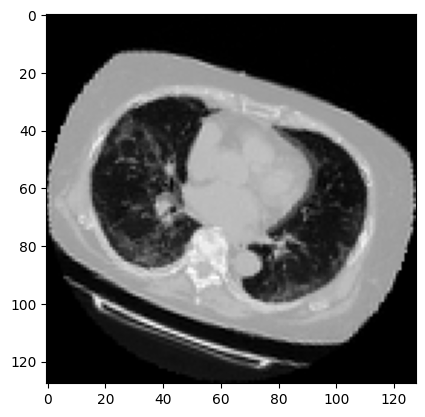

In [12]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("CT scan image shape is :: ", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

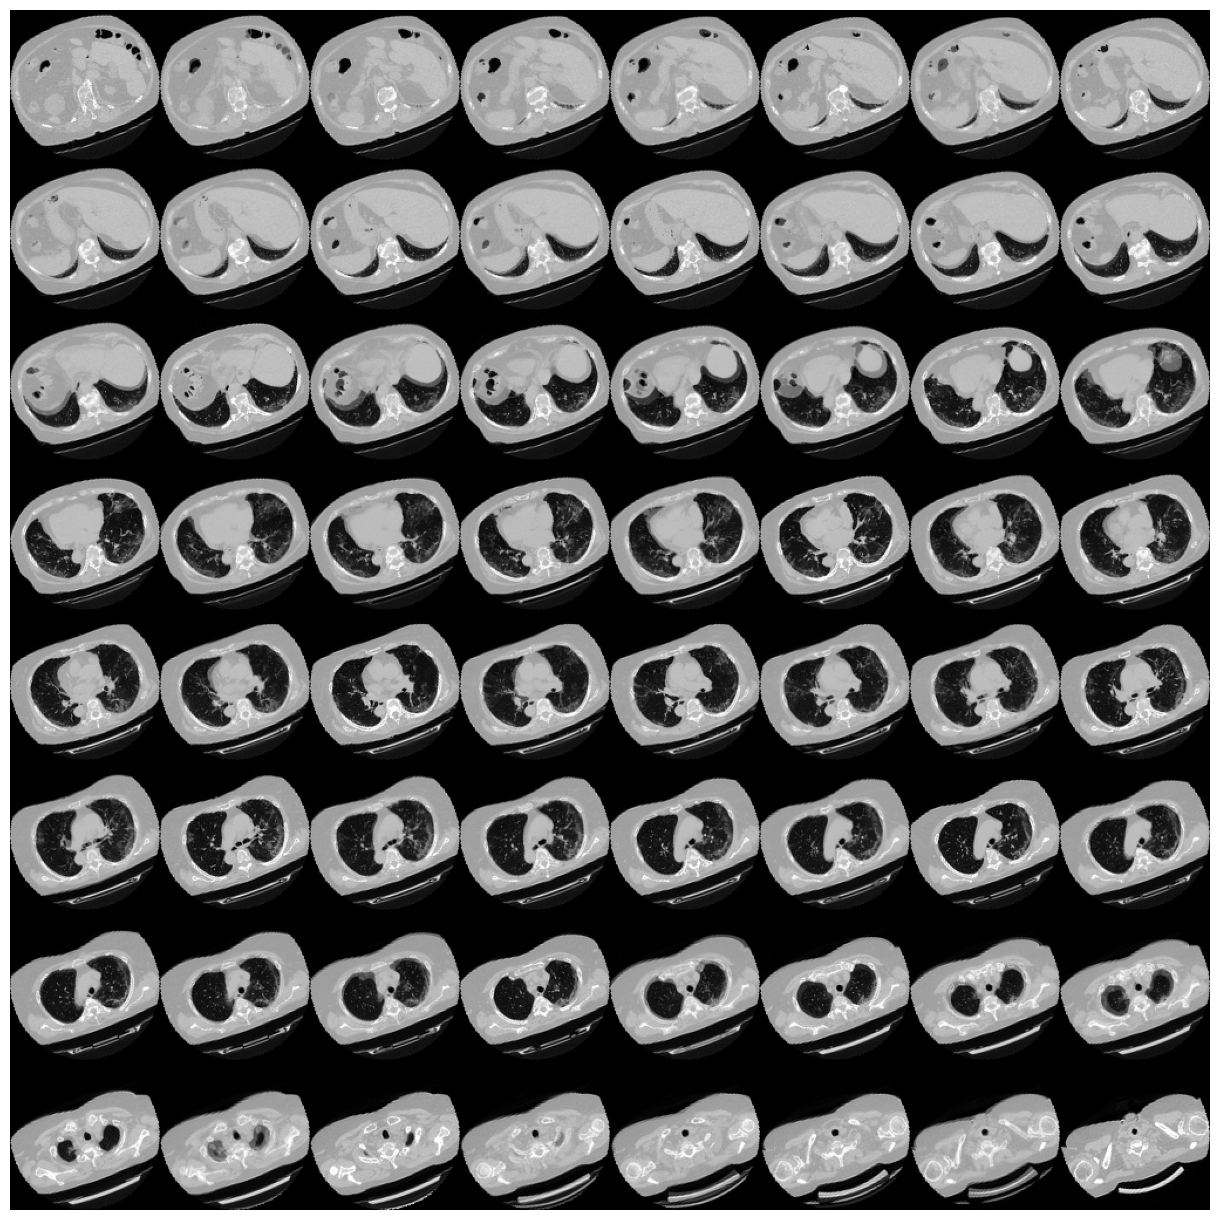

In [13]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(8, 8, 128, 128, image[:, :, :])

##**Build Model**

In [14]:
def build_model(width = 128, height = 128, depth = 64):

    inputs = keras.Input(shape = (width, height, depth, 1))

    x = layers.Conv3D(filters = 64, kernel_size = 3, activation = "relu")(inputs)
    x = layers.MaxPooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters = 64, kernel_size = 3, activation = "relu")(x)
    x = layers.MaxPooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters = 128, kernel_size = 3, activation = "relu")(x)
    x = layers.MaxPooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters = 256, kernel_size = 3, activation = "relu")(x)
    x = layers.MaxPooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(512, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)

    model = keras.Model(inputs, outputs)
    return model

model = build_model(width = 128, height = 128, depth = 64)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1   0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64   1792      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 63, 63, 31, 64)    0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 31, 64)    256       
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656

###**Train Model**
The number of samples is very small (only 200) and we don't specify a random seed. As such, you can expect significant variance in the results.

In [16]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = lr_schedule),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
    run_eagerly=True
    )


checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.keras", save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 15)


model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 100,
    callbacks = [checkpoint_cb, early_stopping_cb],
    shuffle = True)

Epoch 1/100
70/70 [==============================] - 32s 374ms/step - loss: 0.7199 - accuracy: 0.6000 - val_loss: 4.3364 - val_accuracy: 0.5000
Epoch 2/100
70/70 [==============================] - 26s 369ms/step - loss: 0.6857 - accuracy: 0.6357 - val_loss: 0.8214 - val_accuracy: 0.4833
Epoch 3/100
70/70 [==============================] - 26s 369ms/step - loss: 0.6297 - accuracy: 0.6786 - val_loss: 0.8314 - val_accuracy: 0.4833
Epoch 4/100
70/70 [==============================] - 26s 366ms/step - loss: 0.6112 - accuracy: 0.6714 - val_loss: 1.0428 - val_accuracy: 0.4833
Epoch 5/100
70/70 [==============================] - 26s 366ms/step - loss: 0.6081 - accuracy: 0.6286 - val_loss: 0.7737 - val_accuracy: 0.5500
Epoch 6/100
70/70 [==============================] - 27s 381ms/step - loss: 0.5560 - accuracy: 0.6857 - val_loss: 0.7792 - val_accuracy: 0.5667
Epoch 7/100
70/70 [==============================] - 27s 379ms/step - loss: 0.5947 - accuracy: 0.7071 - val_loss: 6.5239 - val_accuracy:

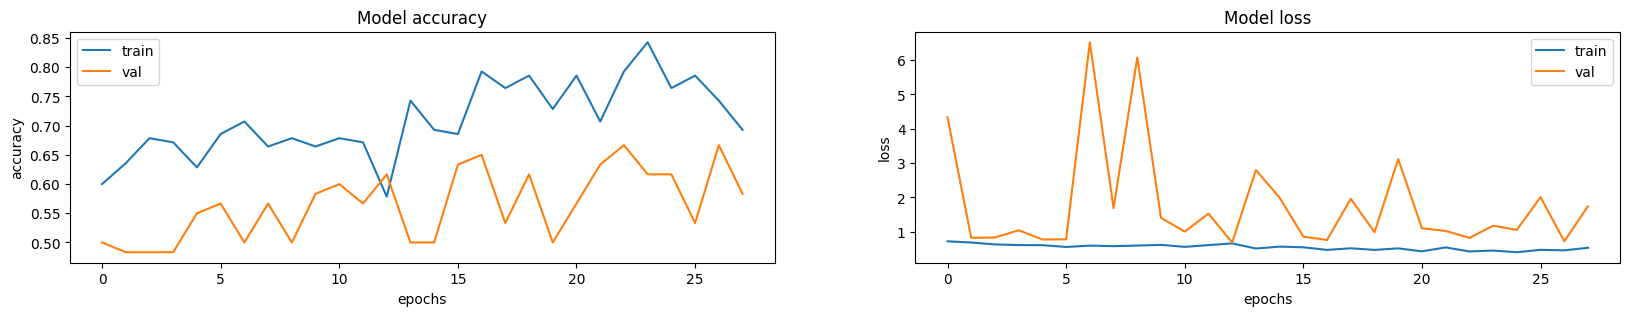

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

##**Prediction**

In [20]:
# Load best weights.
model.load_weights("3d_image_classification.keras")
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

1/1 [==============================] - 1s 714ms/step
This model is 30.16 percent confident that CT scan is normal
This model is 69.84 percent confident that CT scan is abnormal
